<center><h1>Myau_Christopher_HW5</h1></center>
<br>
<br>

Name: Christopher Myau
<br>
Github Username: Miao-Long
<br>
USC ID: 7766956185

## 1. Decision Trees as Interpretable Models

Import packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import datasets
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor

### (a) Obtain Data

Get the Accute Inamations Data Set

In [8]:
columns = ["Temperature", "Nausea", "Lumbar Pain", "Urine Pushing", "Micturition pains", "Urethea Burning", "Bladdar Inflammation", "Nephritis"]
diagnosis_df = pd.read_csv('../Data/diagnosis.data', names=columns, delimiter="\t", encoding='utf-16',decimal=',')
diagnosis_df.head()

X = diagnosis_df.loc[:, diagnosis_df.columns != 'Temperature'].apply(lambda x: x.map({'yes': 1, 'no': 0}))
y = diagnosis_df["Temperature"]

### (b) Build a decision tree

In [9]:
d_dt = tree.DecisionTreeRegressor()
d_dt.fit(X, y)

DecisionTreeRegressor()

### (c) Convert the decision rules

In [10]:
dotfile = open("d_dt.dot", 'w')
tree.export_graphviz(d_dt, out_file=dotfile, feature_names=columns[1:])
dotfile.close()

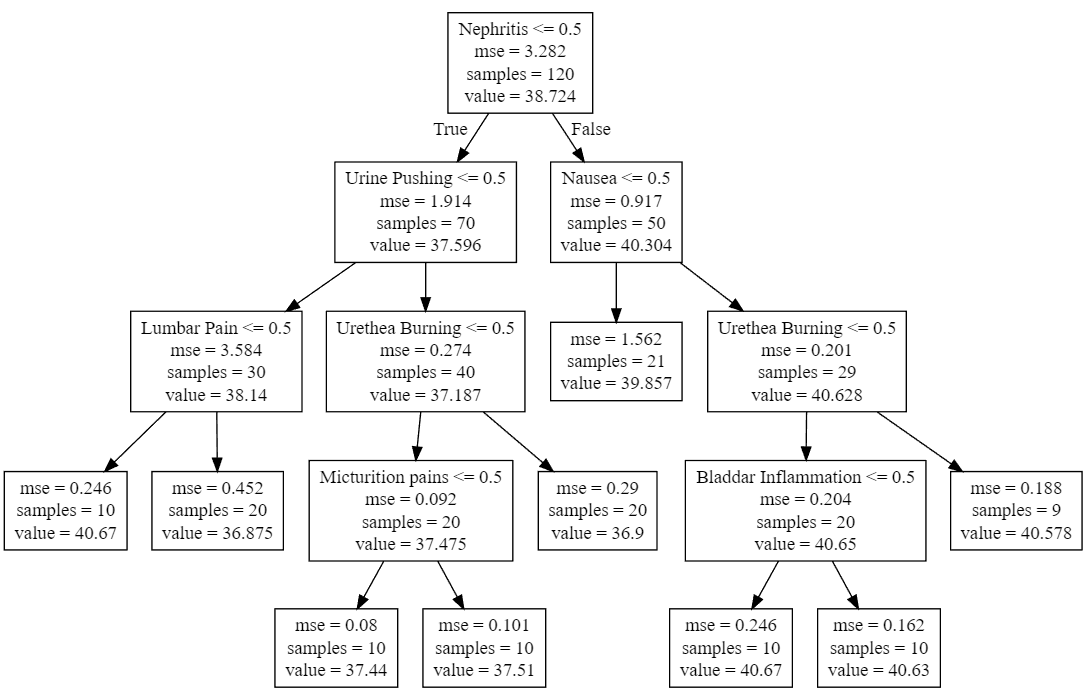

### (d) Prune Tree

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
path = d_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [12]:
d_dts = []
for ccp_alpha in ccp_alphas[:-1]:
    d_dt = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    d_dt.fit(X_train, y_train)
    d_dts.append(d_dt)

train_scores = [d_dt.score(X_train, y_train) for d_dt in d_dts]
test_scores = [d_dt.score(X_test, y_test) for d_dt in d_dts]

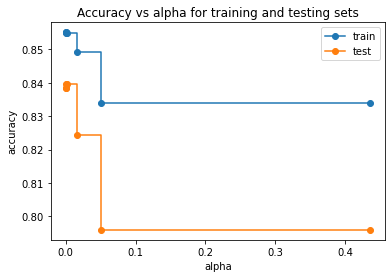

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[:-1], train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [14]:
alpha_df = pd.DataFrame({"ccp alpha":ccp_alphas[:-1], "test scores":test_scores, "train scores":train_scores})
alpha = alpha_df.iloc[alpha_df['test scores'].idxmax()]
d_dt_alpha_opt = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
dotfile = open("d_dt_alpha_opt.dot", 'w')
tree.export_graphviz(d_dt, out_file=dotfile, feature_names=columns[1:])
dotfile.close()

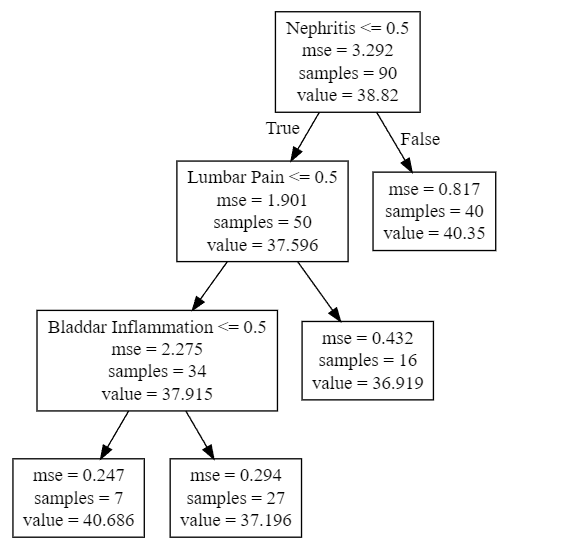

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [15]:
columns = ["state",
"county",
"community",
"communityname",
"fold",
"population",
"householdsize",
"racepctblack",
"racePctWhite",
"racePctAsian",
"racePctHisp",
"agePct12t21",
"agePct12t29",
"agePct16t24",
"agePct65up",
"numbUrban",
"pctUrban",
"medIncome",
"pctWWage",
"pctWFarmSelf",
"pctWInvInc",
"pctWSocSec",
"pctWPubAsst",
"pctWRetire",
"medFamInc",
"perCapInc",
"whitePerCap",
"blackPerCap",
"indianPerCap",
"AsianPerCap",
"OtherPerCap",
"HispPerCap",
"NumUnderPov",
"PctPopUnderPov",
"PctLess9thGrade",
"PctNotHSGrad",
"PctBSorMore",
"PctUnemployed",
"PctEmploy",
"PctEmplManu",
"PctEmplProfServ",
"PctOccupManu",
"PctOccupMgmtProf",
"MalePctDivorce",
"MalePctNevMarr",
"FemalePctDiv",
"TotalPctDiv",
"PersPerFam",
"PctFam2Par",
"PctKids2Par",
"PctYoungKids2Par",
"PctTeen2Par",
"PctWorkMomYoungKids",
"PctWorkMom",
"NumIlleg",
"PctIlleg",
"NumImmig",
"PctImmigRecent",
"PctImmigRec5",
"PctImmigRec8",
"PctImmigRec10",
"PctRecentImmig",
"PctRecImmig5",
"PctRecImmig8",
"PctRecImmig10",
"PctSpeakEnglOnly",
"PctNotSpeakEnglWell",
"PctLargHouseFam",
"PctLargHouseOccup",
"PersPerOccupHous",
"PersPerOwnOccHous",
"PersPerRentOccHous",
"PctPersOwnOccup",
"PctPersDenseHous",
"PctHousLess3BR",
"MedNumBR",
"HousVacant",
"PctHousOccup",
"PctHousOwnOcc",
"PctVacantBoarded",
"PctVacMore6Mos",
"MedYrHousBuilt",
"PctHousNoPhone",
"PctWOFullPlumb",
"OwnOccLowQuart",
"OwnOccMedVal",
"OwnOccHiQuart",
"RentLowQ",
"RentMedian",
"RentHighQ",
"MedRent",
"MedRentPctHousInc",
"MedOwnCostPctInc",
"MedOwnCostPctIncNoMtg",
"NumInShelters",
"NumStreet",
"PctForeignBorn",
"PctBornSameState",
"PctSameHouse85",
"PctSameCity85",
"PctSameState85",
"LemasSwornFT",
"LemasSwFTPerPop",
"LemasSwFTFieldOps",
"LemasSwFTFieldPerPop",
"LemasTotalReq",
"LemasTotReqPerPop",
"PolicReqPerOffic",
"PolicPerPop",
"RacialMatchCommPol",
"PctPolicWhite",
"PctPolicBlack",
"PctPolicHisp",
"PctPolicAsian",
"PctPolicMinor",
"OfficAssgnDrugUnits",
"NumKindsDrugsSeiz",
"PolicAveOTWorked",
"LandArea",
"PopDens",
"PctUsePubTrans",
"PolicCars",
"PolicOperBudg",
"LemasPctPolicOnPatr",
"LemasGangUnitDeploy",
"LemasPctOfficDrugUn",
"PolicBudgPerPop",
"ViolentCrimesPerPop"]

communities_df = pd.read_csv('../Data/communities.data', sep=',')
communities_df.columns = columns
communities_df = communities_df.drop(["state", "county", "community", "communityname", "fold"], axis=1)
communities_df = communities_df.replace({"?":np.nan})
#c_dt = tree.DecisionTreeClassifier(criterion='entropy')

train_df = communities_df.iloc[:1495]
test_df = communities_df.iloc[1495:]

train_df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.0,NaN,0.67
1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.0,NaN,0.43
2,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.0,NaN,0.12
3,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.0,NaN,0.03
4,0.02,0.28,0.06,0.54,1.00,0.25,0.31,0.48,0.27,0.37,...,0.01,0.58,0.10,NaN,NaN,NaN,NaN,0.0,NaN,0.14


### (b) Missing values

In [16]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(communities_df)
train_df = pd.DataFrame(imp.transform(train_df), columns=columns[5:])
test_df = pd.DataFrame(imp.transform(test_df), columns=columns[5:])

### (c) Plot a correlation matrix

<AxesSubplot:>

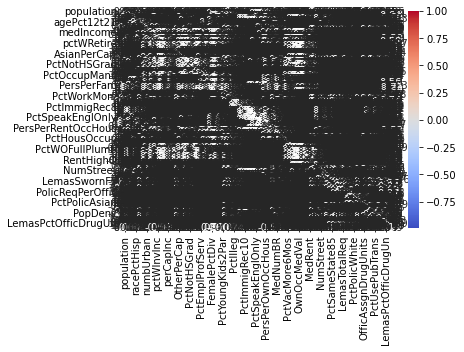

In [17]:
# Compute the correlation matrix
corr = train_df.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr, cmap='coolwarm', annot=True)


### (d) Calculate the Coefficient of Variation CV

In [18]:
coeff_cv = []
cv_df = pd.DataFrame({"features":columns[5:], "CV":train_df.std() / train_df.mean()}, )

### (e) Scatter plots and box plots for highest CV features

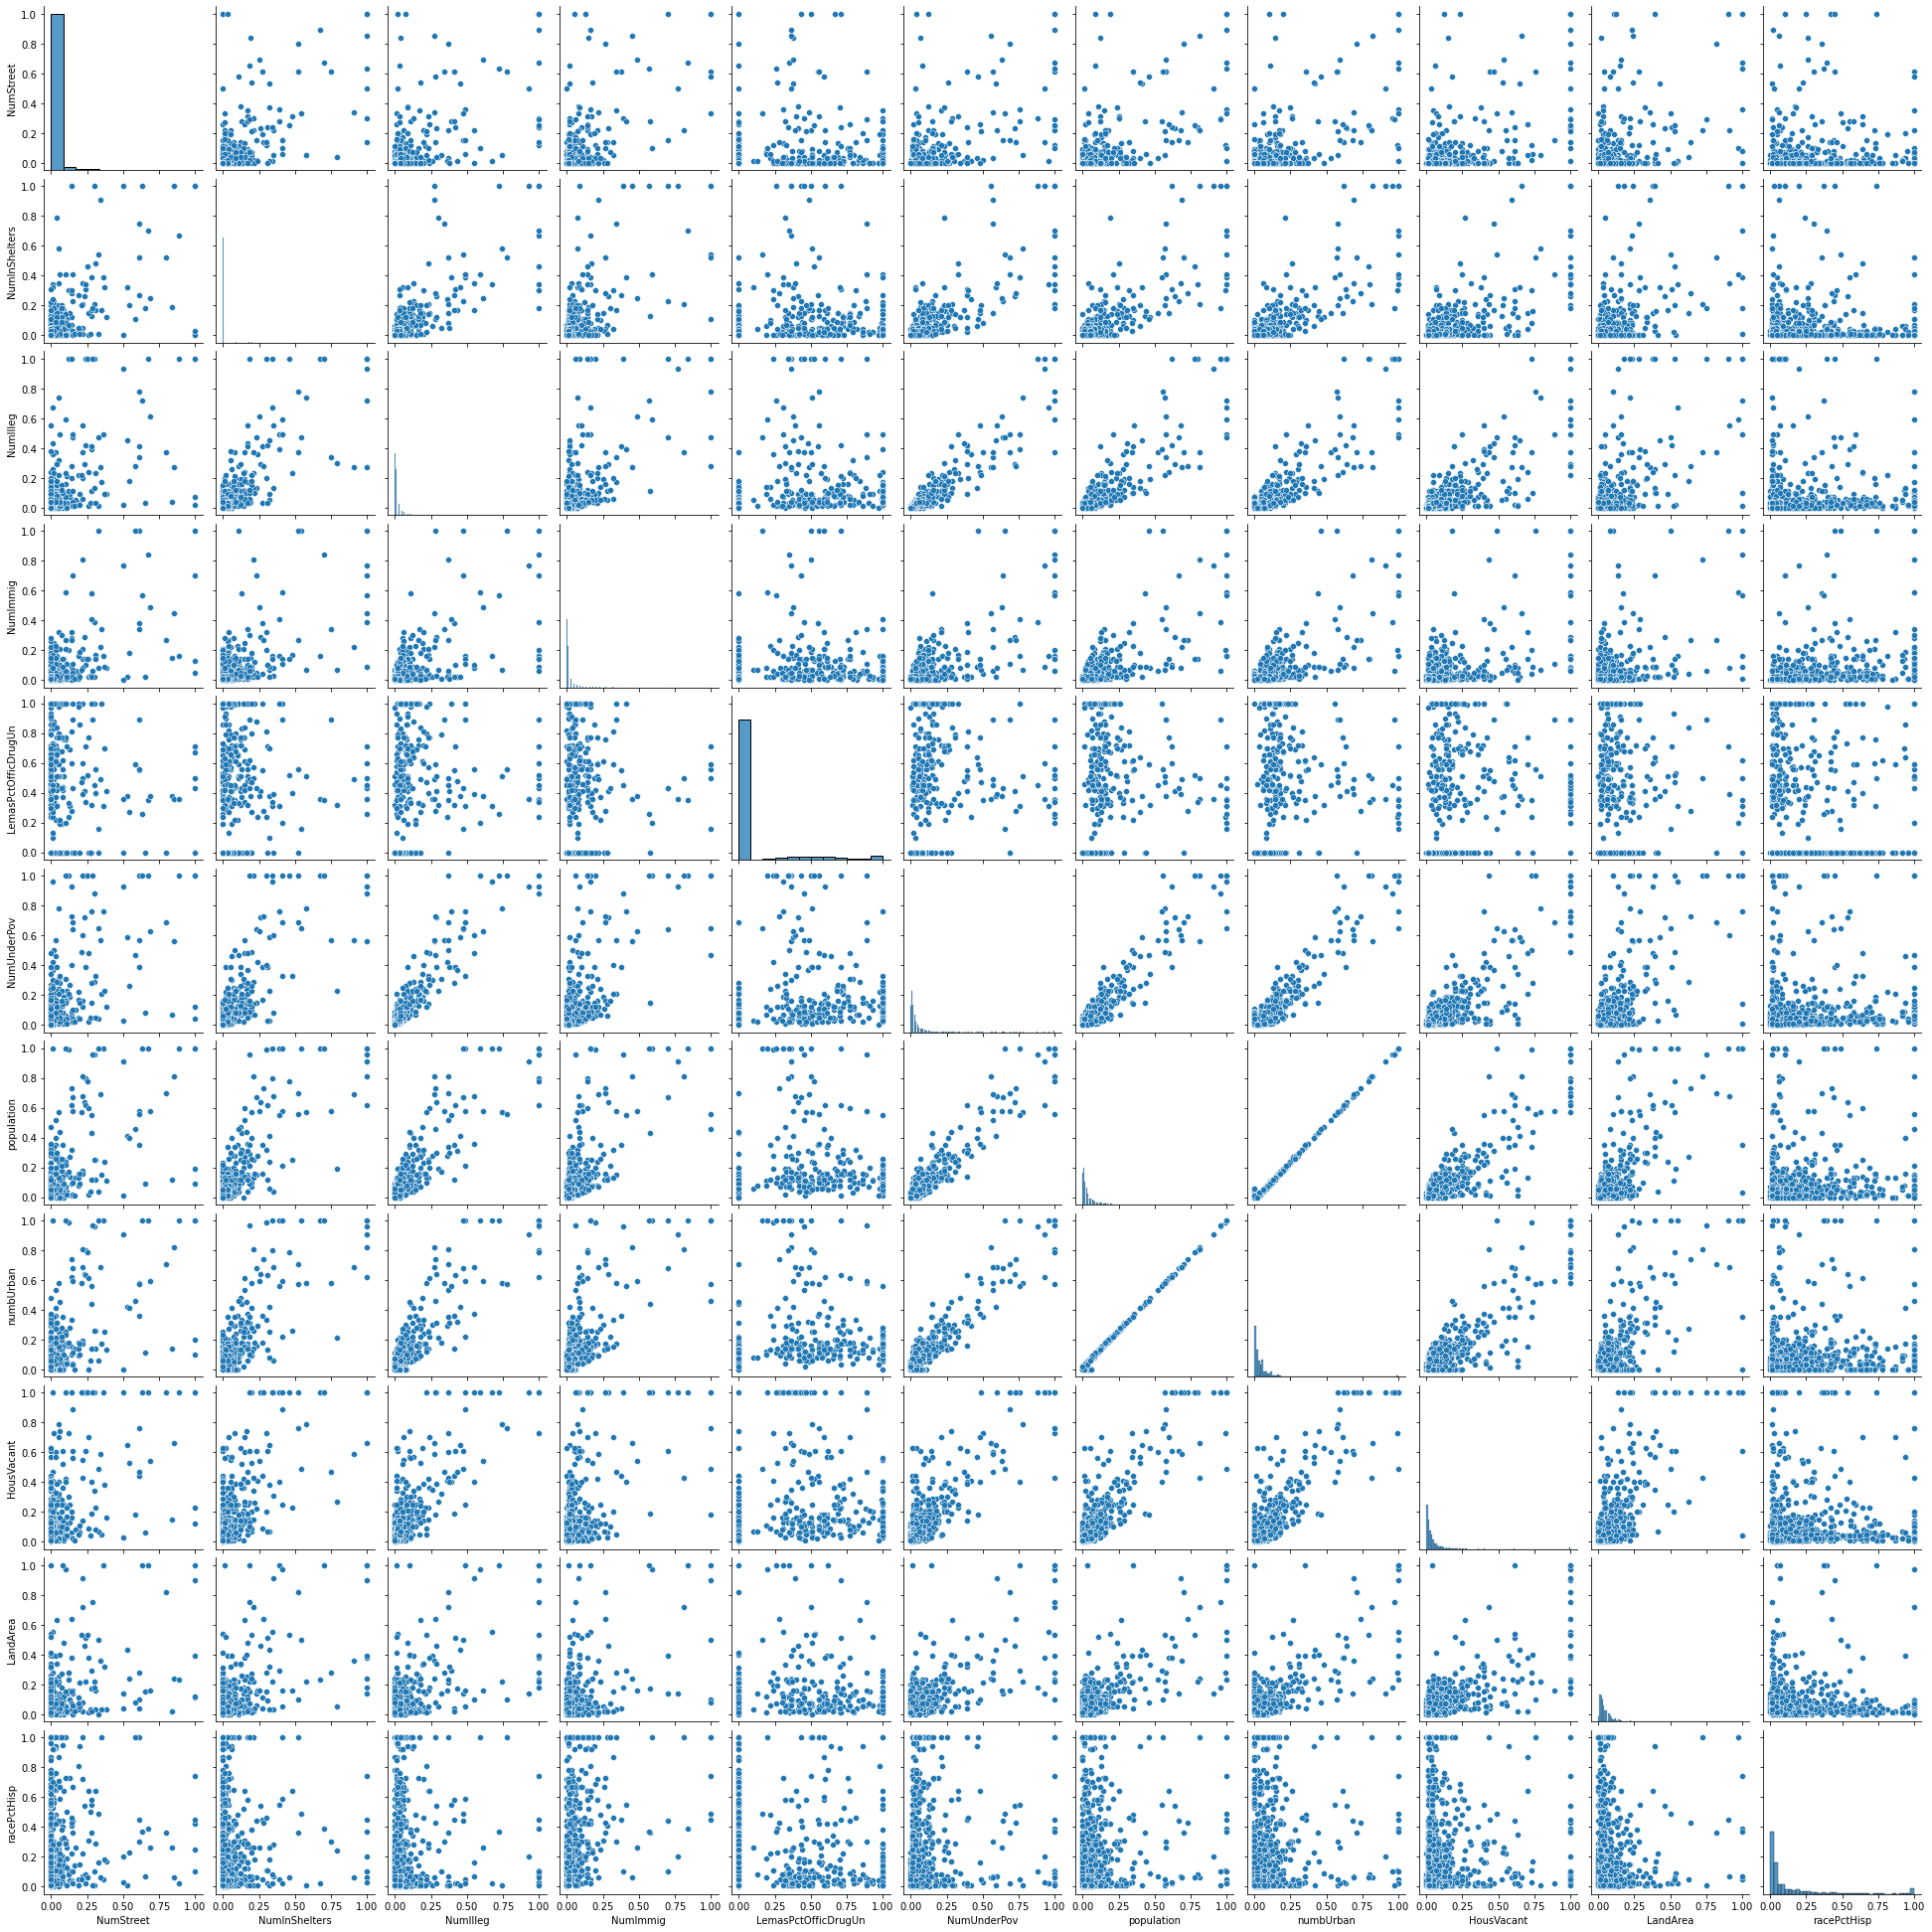

In [19]:
#floor(sqrt(128)) = 11

largestcv_df = cv_df.sort_values('CV', ascending=False).head(11)

sns.pairplot(train_df[largestcv_df["features"]])

<AxesSubplot:>

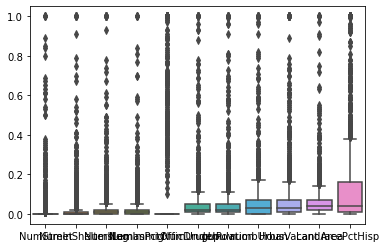

In [20]:
sns.boxplot(data=train_df[largestcv_df["features"]])

Some features in the data set are clearly highly correlated. numbUrban and Population in particular look to be nearly perfectly correlated.

### (f) Fit a linear model

In [21]:
X_train, X_test = train_df.iloc[:,:-1], test_df.iloc[:,:-1]
y_train, y_test = train_df.iloc[:,-1], test_df.iloc[:,-1]

reg = LinearRegression().fit(X_train, y_train)
print(f"Linear Regression Score: {reg.score(X_test, y_test)}")

Linear Regression Score: -15.168421906336736


### (g) Fit a ridge regression model

In [22]:
ridge_clf = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10]).fit(X_train, y_train)
print(f"Ridge Regression Score: {ridge_clf.score(X_test, y_test)}")

Ridge Regression Score: 0.6268095352289806


/Users/a-fu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


### (h) Fit a LASSO model

In [23]:
lasso_clf = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
print(f"Normalized LASSO Score: {lasso_clf.score(X_test, y_test)}")

scalar = StandardScaler()
standardized_train_df = pd.DataFrame(scalar.fit_transform(train_df), columns=columns[5:])
standardized_test_df = pd.DataFrame(scalar.fit_transform(test_df), columns=columns[5:])

sX_train, sy_train, sX_test, sy_test= standardized_train_df.iloc[:,:-1], standardized_train_df.iloc[:,-1], standardized_test_df.iloc[:,:-1], standardized_test_df.iloc[:,-1]
standard_lasso_clf = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_test, y_test)
print(f"Standardized LASSO Score: {standard_lasso_clf.score(sX_test, sy_test)}")

Normalized LASSO Score: 0.631082447902383
Standardized LASSO Score: 0.4978866104490196


Normalized Lasso has a slightly higher score than Ridge Regression, but adding Standardization on top of that only lowers the score.

### (i) Fit a PCR model

In [24]:
parameters = { 'n_components ' : [1, 2, 3]}


pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

cv_scores = []
for M in range(124):
    lr = LinearRegression()
    cv_score = cross_val_score(lr, X_train_pca[:, :M+1], y_train, cv=5)
    cv_scores.append(cv_score.mean())

max_value = max(cv_scores)
index = cv_scores.index(max_value)

In [25]:
reg = LinearRegression().fit(X_train_pca[:, :index+1], y_train)
print(f"PCR Score: {reg.score(X_test_pca[:, :index+1], y_test)}")

PCR Score: 0.611116409753246


### (j) Fit a boosting tree

In [29]:
param_grid = {
    'reg_alpha': [0.001, 0.01, 0.1, 1.0, 10]
}

xgbr = xgb.XGBRegressor()

grid_search = GridSearchCV(xgbr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Test score:", grid_search.score(X_test, y_test))

Best hyperparameters: {'reg_alpha': 1.0}
Test score: -0.01774007123362265
